In [158]:
from utils.io import load
fn = '/Users/stathis/Code/thesis/wave_propagation/experiments_results/ConvLSTM_batch16_samples_5_epoch30_out1/pickles/metadata.pickle.json'

In [159]:
# load(fn)

In [160]:
import json
import jsons
with open(fn) as f:
    dd = json.load(f)g

In [154]:
import math 
num_total_frames = 100
num_output_frames = 10
num_input_frames = 5
for starting_point in range(0, num_total_frames, 10):
    num_requested_output_frames = math.floor(math.floor((num_total_frames - num_input_frames - 
                                              starting_point) / num_output_frames) * num_output_frames / 10) * 10
    print(starting_point, num_requested_output_frames)

0 90
10 80
20 70
30 60
40 50
50 40
60 30
70 20
80 10
90 0


In [58]:
from models.AR_LSTM import AR_LSTM
modelAR = AR_LSTM(5, 10, None)

In [59]:
summary(modelAR, (5,128,128), batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 60, 62, 62]          14,760
       BatchNorm2d-2           [16, 60, 62, 62]             120
              Tanh-3           [16, 60, 62, 62]               0
            Conv2d-4          [16, 120, 31, 31]          64,920
       BatchNorm2d-5          [16, 120, 31, 31]             240
              Tanh-6          [16, 120, 31, 31]               0
            Conv2d-7          [16, 240, 16, 16]         259,440
       BatchNorm2d-8          [16, 240, 16, 16]             480
              Tanh-9          [16, 240, 16, 16]               0
           Conv2d-10            [16, 480, 8, 8]       1,037,280
      BatchNorm2d-11            [16, 480, 8, 8]             960
             Tanh-12            [16, 480, 8, 8]               0
        Dropout2d-13            [16, 480, 8, 8]               0
           Linear-14                 [1

In [118]:
sum([param.nelement() for param in modelAR.parameters()]) / 10**6

88.236521

In [116]:
sum([param.nelement() for param in modelCL.parameters()])  / 10**6

12.319529

In [109]:
modelCL = get_convlstm_model(5, 10, 10, 16, 'cpu')
# summary(modelCL, (10,128,128), batch_size=16, device='cpu')

In [19]:
from torchsummary import summary

In [49]:
class argsclass():
    pass
args = argsclass()

In [62]:
import sys
sys.path.append('..')
sys.path.append('../..')
import logging
import torch
import os
import matplotlib.pyplot as plt
from models.ConvLSTM import get_convlstm_model
from utils.experiment import Experiment
from utils.plotting import save_sequence_plots
plt.ioff()

logging.basicConfig(format='%(message)s', level=logging.INFO)

# args = get_args_test()
args.experiment_name='ConvLSTM_batch6_samples5_epoch25' 
args.num_workers = 1
args.batch_size=1
args.normalizer_type='normal'
args.test_starting_point=15
args.show_plots=True
args.debug=True

setup = Experiment(args)
# metadata = load_metadata(setup.files['metadata'])
# print(metadata)
# get normalizer from metadata
# normalizer = get_normalizer(args.normalizer_type)
# TODO make this load_dataloaders
datasets = load_datasets(setup.files['datasets'])
datasets['Testing data'].root_dir = setup.dirs['data']
datasets['Testing data'].transform = get_transforms(normalizer)['Test']
data_loaders = create_dataloaders(datasets, args.batch_size, args.num_workers)
# up to here
device = get_device()

model = get_convlstm_model(metadata['args'].num_input_frames, metadata['args'].num_output_frames, args.batch_size, device)
model = load_network(model, setup.files['model'])
model.to(device)

score_keeper = Scorekeeper(setup.dirs['charts'], normalizer)

logging.info("Start testing")
# with torch.no_grad():
#     test_convlstm(model, data_loaders['test'], args.test_starting_point, device, score_keeper, setup.dirs['predictions'], args.show_plots, debug=args.debug, normalize=normalizer)
# score_keeper.plot(args.show_plots)

Experiment ConvLSTM_batch6_samples5_epoch25
use CPU
Loading datasets


NameError: name 'get_transforms' is not defined

In [5]:
dataloader= data_loaders['test'] 
figures_dir = setup.dirs['predictions']
normalize=normalizer
show_plots=True
debug=True

starting_point = 15 
num_keep_output_frames = 10
num_requested_output_frames = 20

Testing batch 1 out of 490


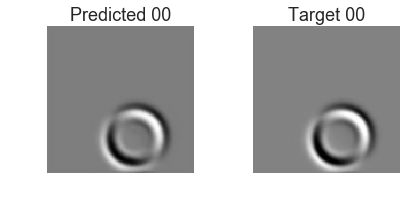

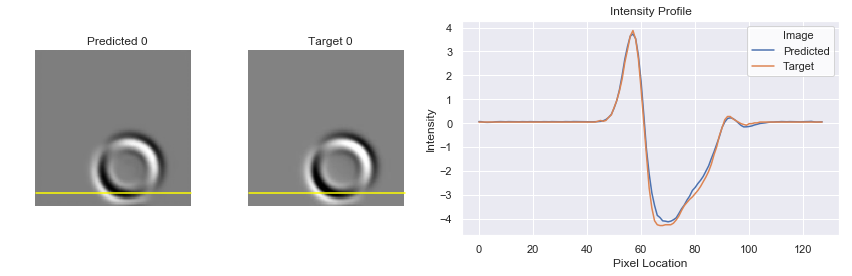

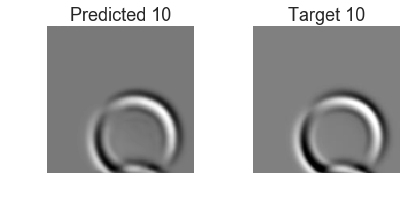

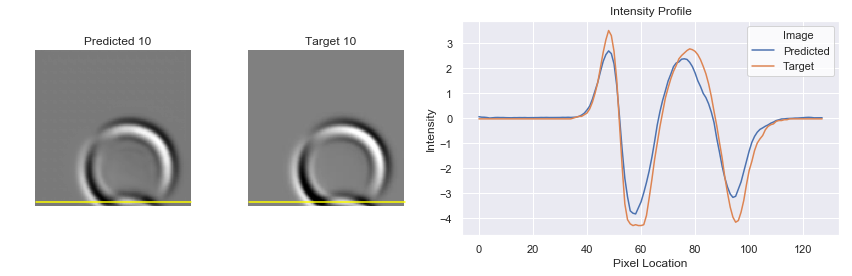

In [6]:
test_convlstm(model, dataloader, starting_point, num_keep_output_frames,
              num_requested_output_frames, device, score_keeper, figures_dir,
              show_plots, debug=debug, normalize=normalizer)

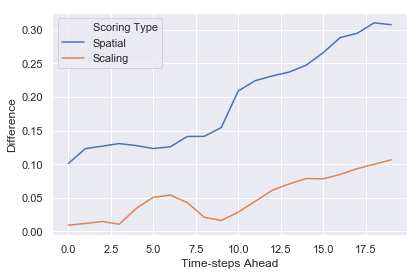

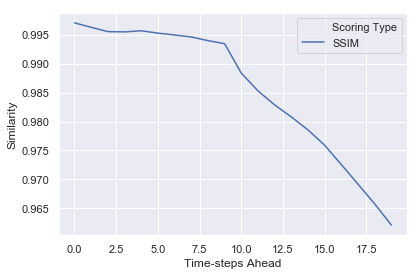

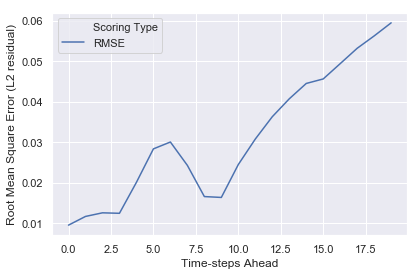

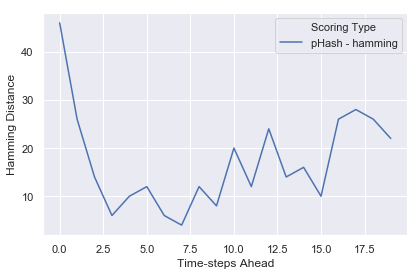

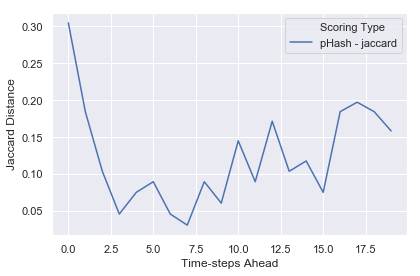

In [7]:
score_keeper.plot()

Testing batch 1 out of 490


torch.Size([1, 10, 128, 128])


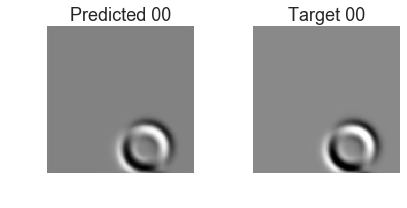

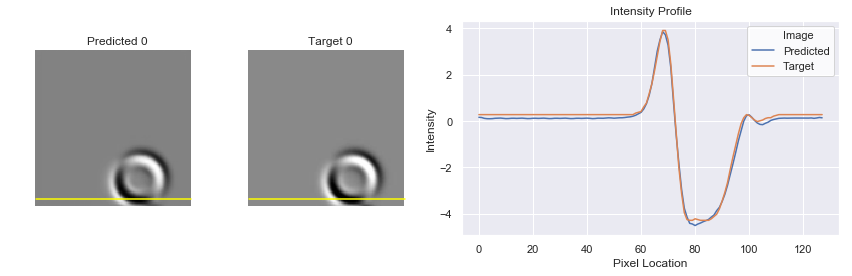

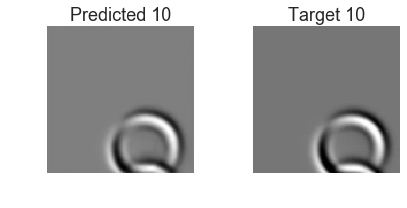

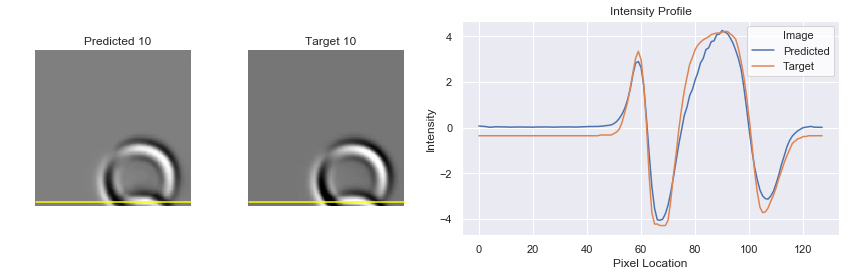

In [22]:
import random
from utils.plotting import save_prediction_plot, save_cutthrough_plot
from utils.Scorekeeper import Scorekeeper
score_keeper = Scorekeeper(setup.dirs['charts'], normalizer)

starting_point = 15 
num_keep_output_frames = 10
num_requested_output_frames = 20

with torch.no_grad():
    model.eval()
    num_input_frames = model.get_num_input_frames()
    num_output_frames = model.get_num_input_frames()
    
    for batch_num, batch_images in enumerate(dataloader):
        logging.info("Testing batch {:d} out of {:d}".format(batch_num + 1, len(dataloader)))
        batch_images = batch_images.to(device)
        batch_size = batch_images.size(0)

        # total_frames = batch_images.size()[1]
        # num_future_frames = total_frames - (starting_point + num_input_frames)

        input_frames = batch_images[:, starting_point:(starting_point + num_input_frames), :, :].clone()
        output_frames = model.forward(input_frames)[:, :num_output_keep_frames, :, :]

        num_discard_frames = num_output_frames - num_input_frames
        while output_frames.size(1) < num_requested_output_frames:
            print(output_frames.size())
            input_frames = output_frames[:, -num_input_frames:, :, :].clone()
            output_keep_frames = model.forward(input_frames)[:, :num_output_keep_frames, :, :]
            output_frames = torch.cat((output_frames, output_keep_frames), dim=1)

        num_total_output_frames = output_frames.size(1)
        input_end_point = starting_point + num_input_frames
        target_frames = batch_images[:, input_end_point:(input_end_point + num_total_output_frames), :, :]
    
        score_keeper.compare_output_target(output_frames, target_frames)

        batch_index = 0
        save_sequence_plots(batch_index, output_frames, target_frames, figures_dir, normalize)
        
        if debug:
            break